In [25]:
import re
import pandas as pd
from datetime import datetime
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [26]:
log_pattern = re.compile(
    r'(?P<ip>\S+) \S+ \S+ \[(?P<time>.*?)\] "(?P<method>\S+) (?P<url>\S+) \S+" (?P<status>\d{3}) (?P<size>\S+) (?P<duration>\d+) "(?P<referer>.*?)" "(?P<agent>.*?)"'
)

def parse_log_line(line):
    match = log_pattern.match(line)
    if match:
        return match.groupdict()
    return None

log_file_path = '/var/log/apache2/access.log'
log_data = []

with open(log_file_path, 'r') as file:
    for line in file:
        parsed_line = parse_log_line(line)
        if parsed_line:
            log_data.append(parsed_line)

df = pd.DataFrame(log_data)

df['status'] = df['status'].astype(int)
df['size'] = df['size'].replace('-', 0).astype(int)
df['duration'] = df['duration'].astype(int)
df['time'] = pd.to_datetime(df['time'], format='%d/%b/%Y:%H:%M:%S %z')

def calculate_features(df):
    df['protocol_type'] = 'HTTP' 
    df['service'] = df['url'].apply(lambda x: x.split('/')[1] if '/' in x else x)
    df['flag'] = df['status'].apply(lambda x: 'SF' if x == 200 else 'REJ')
    df['src_bytes'] = df['size']
    df['dst_bytes'] = df['size'] 

    df['count'] = df.groupby('ip')['ip'].transform('count')
    df['same_srv_rate'] = df.groupby('ip')['service'].transform(lambda x: x.value_counts(normalize=True).max())
    df['diff_srv_rate'] = 1 - df['same_srv_rate']
    df['dst_host_srv_count'] = df.groupby('service')['service'].transform('count')
    df['dst_host_same_srv_rate'] = df.groupby('service')['service'].transform(lambda x: x.value_counts(normalize=True).max())
    
    return df[['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate']]


feature_df = calculate_features(df)
print("\nOriginal Data")
print("-" * 140)
print(feature_df.head())

def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df.loc[:, col] = label_encoder.fit_transform(df[col])
le(feature_df)
print("\nProcessed Data")
print("-" * 140)
print(feature_df.head())


Original Data
--------------------------------------------------------------------------------------------------------------------------------------------
  protocol_type        service flag  src_bytes  dst_bytes  count  \
0          HTTP  products.html  REJ        271        271     30   
1          HTTP     about.html  REJ        271        271     30   
2          HTTP  products.html  REJ        271        271     30   
3          HTTP  products.html  REJ        271        271     30   
4          HTTP   contact.html  REJ        271        271     30   

   same_srv_rate  diff_srv_rate  dst_host_srv_count  dst_host_same_srv_rate  
0       0.266667       0.733333                   8                     1.0  
1       0.266667       0.733333                   3                     1.0  
2       0.266667       0.733333                   8                     1.0  
3       0.266667       0.733333                   8                     1.0  
4       0.266667       0.733333              

In [30]:
model = joblib.load('model.joblib')

# original_data = pd.read_csv('Datasets/Train_data.csv')
# X_original = original_data.drop(columns=['class'])
# y_original = original_data['target']

sample_data = feature_df.values
predictions = model.predict(sample_data)
print("\nPredictions:")
for i in predictions:
    print(i)


Predictions:
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


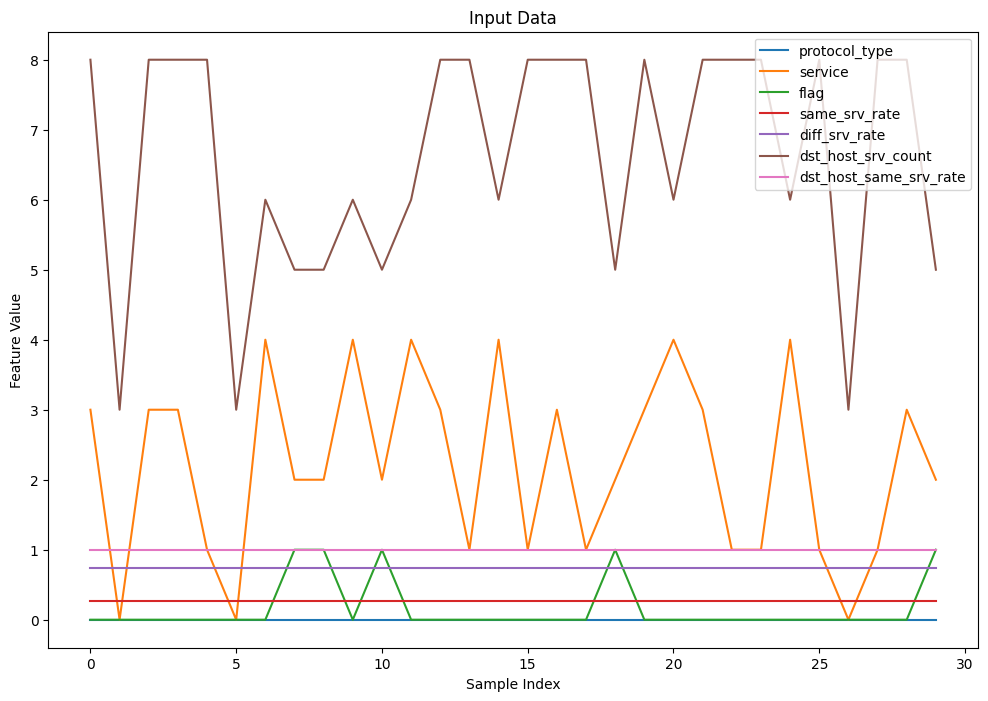

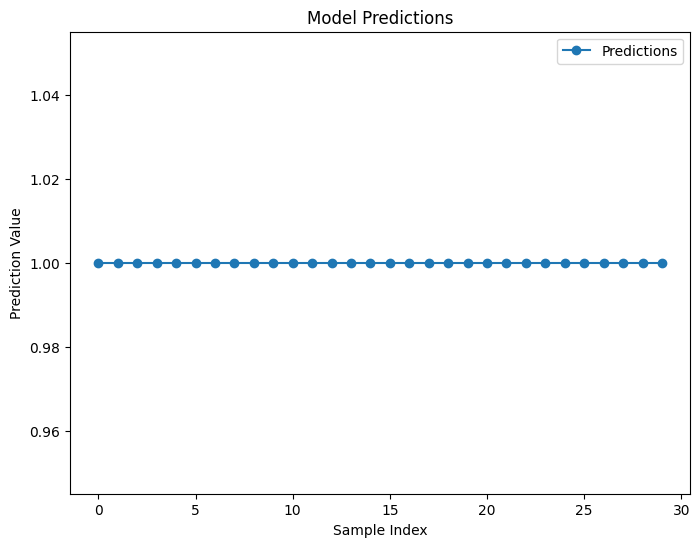

In [31]:
import matplotlib.pyplot as plt
import random

# predictions = [0]*20 + [1]*20
# random.shuffle(predictions)

plt.figure(figsize=(12, 8))
for column in feature_df.columns:
    if column == 'dst_bytes' or column == 'src_bytes' or column == 'count':
        continue
    plt.plot(feature_df[column], label=column)
# plt.plot(predictions, label='Predictions', marker='o')
plt.title('Input Data')
plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.legend()
plt.show()

# Plot Predictions
plt.figure(figsize=(8, 6))
plt.plot(predictions, label='Predictions', marker='o')
plt.title('Model Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Value')
plt.legend()
plt.show()